# Face detection

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def plot_pictures(pictures: list[np.ndarray], titles: list[str] = None) -> tuple[plt.Figure, np.ndarray]:
    '''
    Adaptively compute number of rows and columns for given list of images
    and plot them with given titles.
    '''
    n = len(pictures)

    if titles is None:
        titles = [''] * n

    rows = int(np.sqrt(n))
    cols = int(np.ceil(n / rows))
    fig, axs = plt.subplots(rows, cols)

    if n == 1: axs = np.array([axs])
    axs = axs.flatten()

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j

            if idx < n:
                axs[idx].imshow(cv2.cvtColor(pictures[idx], cv2.COLOR_BGR2RGB))
                axs[idx].set_title(titles[idx])
                axs[idx].axis('off')
            else:
                axs[idx].axis('off')
                axs[idx].set_visible(False)

    return fig, axs

## HAAR like features for face searching

Blazingly fast as it only requires 60-ish cpu instructions to compute haar feature from integral image [Viola-Jones, 2004]

In [11]:
cc_haar = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
cap = cv2.VideoCapture(0)

ret, frame = cap.read()

while ret:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = cc_haar.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    ret, frame = cap.read()

cap.release()
cv2.destroyAllWindows()
del cap

HAAR neither has stable detection rate nor is robust to rotation and occlusion. Something we would want to tackle occlusion and rotation as the faces in daily life candid photography suffers from these cases quiet often.

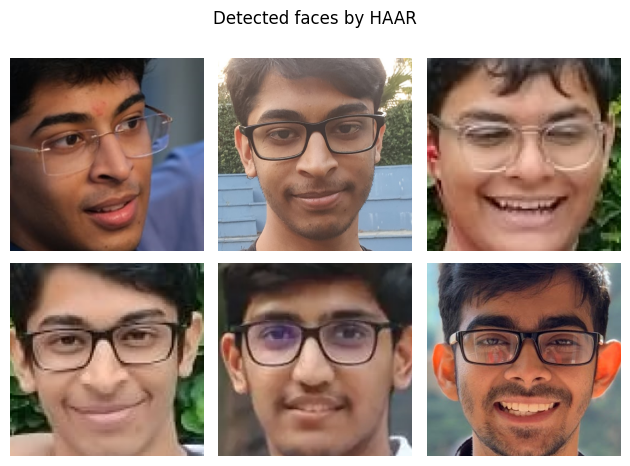

In [12]:
import os

face_imgs = []

for img in os.listdir('data/test_faces/'):
    img = cv2.imread('data/test_faces/' + img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = cc_haar.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_imgs.append(img[y:y+h, x:x+w])

fig = plot_pictures(face_imgs)[0]
fig.suptitle('Detected faces by HAAR')
fig.tight_layout();

## MTCNN

### Stages of MTCNN

1. Proposal Network (P-Net):

    A fully convolutional network generates candidate face regions by producing bounding boxes and scores for potential faces.
    It applies a sliding window approach across the image. Applies Non-Maximum Suppression (NMS) reduces overlapping candidate boxes.

    Outputs include:

    * Bounding box coordinates.
    * A confidence score for each detected region.

2. Refinement Network (R-Net):

    Refines the bounding boxes from P-Net by rejecting false positives.

    Produces:

    * Refined bounding box coordinates.
    * Confidence scores.
    * Landmark locations (optional).

3. Output Network (O-Net):

    Further improves the bounding box accuracy.
    Outputs high-quality landmarks and final bounding boxes.

### How It Detects Faces

Pipeline Overview:

1. The input image is resized to multiple scales (image pyramid).
2. P-Net processes each scale to generate face proposals.
3. R-Net refines these proposals.
4. O-Net produces the final bounding boxes and landmarks.

Core Techniques:

1. Sliding Window: Searches the image at various scales for potential faces.
2. Bounding Box Regression: Refines box coordinates to better enclose the face.
3. Landmark Detection: Locates key facial points for alignment.

In [5]:
import mtcnn

mtcnn_model = mtcnn.MTCNN()

Adheesh_beard_headphone.jpg
1/1 [==============================] - 0s 161ms/step
Adheesh_new_specs_without_beard.png
1/1 [==============================] - 0s 51ms/step
Adheesh_occluded.jpg
1/1 [==============================] - 0s 45ms/step
Adheesh_selfie.jpg
1/1 [==============================] - 0s 51ms/step
Adheesh_with_aryan.jpg
1/1 [==============================] - 0s 41ms/step
Not_adheesh_1.webp
1/1 [==============================] - 0s 46ms/step
Not_adheesh_2.jpeg
1/1 [==============================] - 0s 53ms/step
Not_adheesh_3.jpg
1/1 [==============================] - 0s 45ms/step


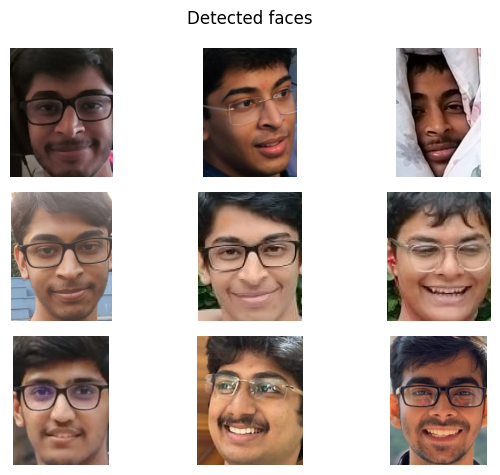

In [ ]:
import os

face_imgs = []

for img in os.listdir('data/test_faces/'):
    print(img)
    img = cv2.imread('data/test_faces/' + img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = mtcnn_model.detect_faces(img_rgb)
    for face in faces:
        (x, y, w, h) = face['box']
        x -= w // 10
        w = int(w * 1.1)
        y -= h // 10
        h = int(h * 1.1)
        asp_ratio = w / h
        face_imgs.append(img[y:y+h, x:x+w])

fig = plot_pictures(face_imgs)[0]
fig.suptitle('Detected faces by MTCNN')
fig.tight_layout();

Works very accurately, but extremely slow. Let's speed it up using GPU! Using pytorch implementation of MTCNN we can utilize the Nvidia GPUs using CUDA.

In [14]:
import facenet_pytorch as fpt

mtcnn_model = fpt.MTCNN()

c:\Users\adhtr\scoop\apps\python39\3.9.13\lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_d

Adheesh_beard_headphone.jpg
Adheesh_new_specs_without_beard.png
Adheesh_occluded.jpg
Adheesh_selfie.jpg
Adheesh_with_aryan.jpg
Not_adheesh_1.webp
Not_adheesh_2.jpeg
Not_adheesh_3.jpg


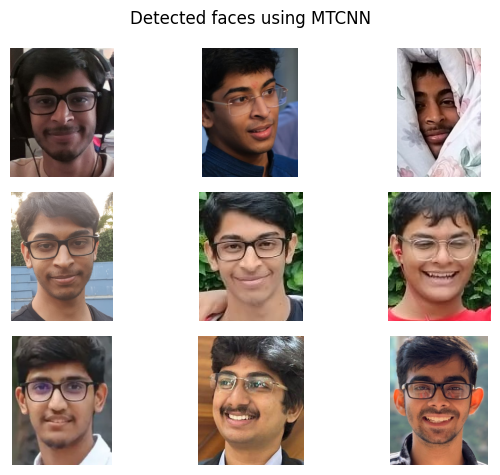

In [22]:
import os

face_imgs = []

for img in os.listdir('data/test_faces/'):
    print(img)
    img = cv2.imread('data/test_faces/' + img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = mtcnn_model.detect(img_rgb)
    if faces[0] is None:
        continue
    for face in faces[0]:
        (x0, y0, x1, y1) = map(int, face)
        x0 -= max(0, int((x1 - x0) * .2))
        x1 += int((x1 - x0) * .2)
        y0 -= max(0, int((y1 - y0) * .2))
        y1 += int((y1 - y0) * .2)
        face_imgs.append(img[y0:y1, x0:x1])

fig = plot_pictures(face_imgs)[0]
fig.suptitle('Detected faces using MTCNN')
fig.tight_layout();

In [24]:
cap = cv2.VideoCapture(0)

ret, frame = cap.read()

while ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = mtcnn_model.detect(frame_rgb)
    if faces[0] is not None:
        for face in faces[0]:
            (x0, y0, x1, y1) = map(int, face)
            x0 -= min(0, int((x1 - x0) * .2))
            x1 += int((x1 - x0) * .2)
            y0 -= min(0, int((y1 - y0) * .2))
            y1 += int((y1 - y0) * .2)
            cv2.rectangle(frame, (x0, y0), (x1, y1), (255, 0, 0), 2)
    cv2.imshow('Face detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    ret, frame = cap.read()

cap.release()
cv2.destroyAllWindows()
del cap

The above code utilizes GPU and shows that the model can run realtime in a basic laptop GPU! So it's impressively fast!